In [47]:
# For dates
import datetime as dt
from dateutil.relativedelta import relativedelta

# For data analysis
import dtale
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# External resources
from yahoo_fin.stock_info import get_data

In [35]:
%matplotlib inline

First, we would obtain the data for one company and analyze it.

Then, once we know how this is done manually, we will automate this extraction.

This data will be stored in our database, as well as in a S3 bucket.

# Amazon Prices Weekly

In [111]:
# If we have no data of the company, we extract last 3 years
to_substract = datetime.date.today() - relativedelta(years=3)

In [112]:
amazon_weekly= get_data(
    "amzn", 
    start_date=to_substract, 
    index_as_date = True, 
    interval="1d")

In [113]:
dtale.show(amazon_weekly)

/home/nil/Documents/Projects/forecasting-app/injestion/venv/lib/python3.10/site-packages/dtale/views.py:832: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [114]:
# We will now make an analysis of this data
amazon_weekly.describe()

,open,high,low,close,adjclose,volume
count,755.000000,755.000000,755.000000,755.000000,755.000000,7.550000e+02
mean,141.561710,143.315680,139.671095,141.486505,141.486505,7.920015e+07
std,29.443129,29.607428,29.118747,29.310171,29.310171,3.526958e+07
min,82.075500,86.250000,81.301498,83.830498,83.830498,1.762600e+07
25%,117.084999,119.000248,115.428249,116.884998,116.884998,5.548300e+07
50%,154.913498,156.644501,151.856995,154.474503,154.474503,6.881800e+07
75%,164.783997,166.318756,162.964256,164.654999,164.654999,9.316200e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.113460e+08


### Handling NaNs

In [115]:
# Check if there are any null values
amazon_weekly.isnull().sum(axis=0)

open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64

In [116]:
# We would not know if for some company we would have any null value, and is something we would have to handle
if amazon_weekly.isnull().any().sum() != 0:
    
    # We wou'ld fill the na with the last valid value
    amazon_weekly.fillna(method="backfill")

In [117]:
# A function would be like the following
def handle_nan(df, method="backfill"):
    
    return df.fillna(method=method)

### Visualize Evolution

Text(0, 0.5, 'Price in $ of each Share')

2022-09-26 12:40:55,044 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,046 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,048 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,051 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,053 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,056 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,059 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,064 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,068 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,071 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,081 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,084 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,088 - WA

2022-09-26 12:40:55,360 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,362 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,364 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,367 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,369 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,372 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,375 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,376 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,382 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,385 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,387 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,390 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:40:55,392 - WA

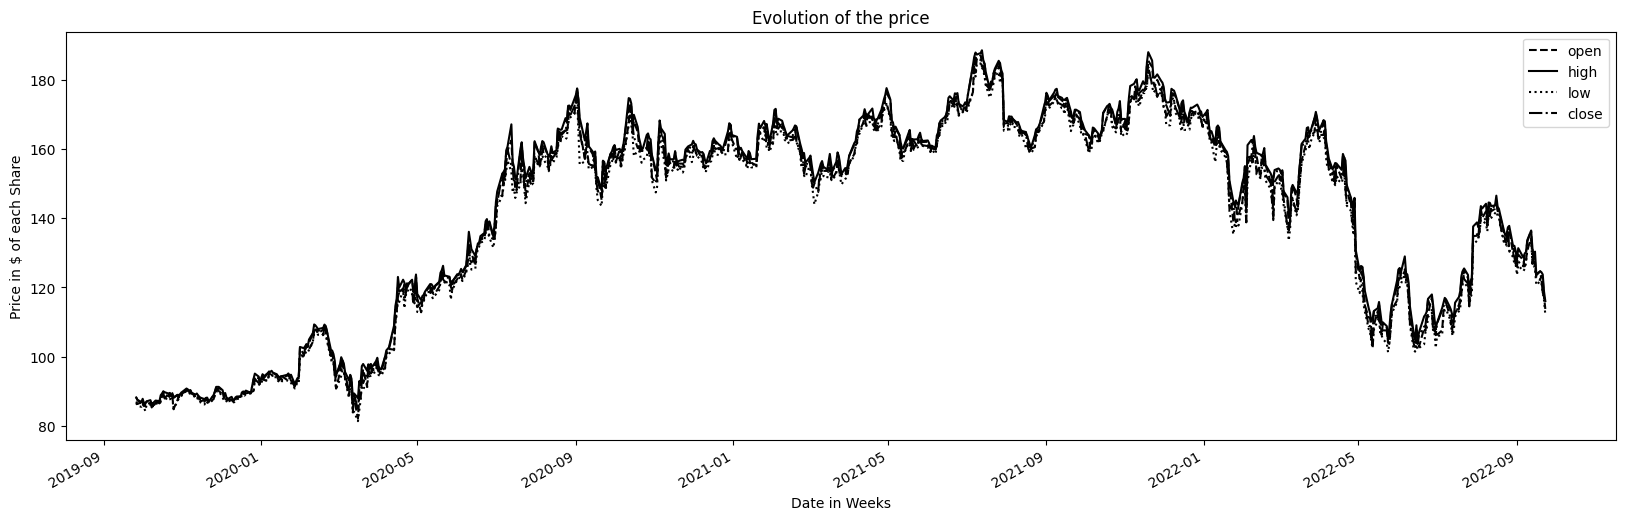

In [118]:
# We can make a plot of the evolution of the prices
amazon_weekly["open"].plot(figsize=(20,6), linestyle="--", color="black", legend="Open Price of Week")
amazon_weekly["high"].plot(figsize=(20,6), linestyle="-", color="black", legend="High Price of Week")
amazon_weekly["low"].plot(figsize=(20,6), linestyle=":", color="black", legend="Low Price of Week")
amazon_weekly["close"].plot(figsize=(20,6), linestyle="-.", color="black", legend="Close Price of Week")

plt.title("Evolution of the price")
plt.xlabel("Date in Weeks")
plt.ylabel("Price in $ of each Share")

### Handling Outliers

In this case we do not have outliers, but it is one scenario we would have to handle.

There are two ways to check for outliers:
- **Inter-Quantile Range**: we use extreme percentil values, of 5% and 95%, to minimize risk of removing correct data points.
- **Z-Score**: represents the distance of the data point in the number of standard deviations away from mean. For a large dataset, for the rule of large numbers, there is 1% chance of a data point having a value of >= 3.

In [119]:
# We will use stats to compute the z-score
prices_amazon = amazon_weekly.drop(["adjclose", "volume", "ticker"], axis=1)

In [120]:
# We can compute the Z-Score in the following way
stats.zscore(prices_amazon)

,open,high,low,close
2019-09-26,-1.815623,-1.863848,-1.824642,-1.860468
2019-09-27,-1.840756,-1.887929,-1.855021,-1.885032
2019-09-30,-1.876458,-1.907633,-1.862925,-1.867176
2019-10-01,-1.844154,-1.876978,-1.829951,-1.867620
2019-10-02,-1.875184,-1.922115,-1.870176,-1.905892
...,...,...,...,...
2022-09-19,-0.659392,-0.628829,-0.614138,-0.574465
2022-09-20,-0.618949,-0.639306,-0.636819,-0.658792
2022-09-21,-0.648177,-0.660937,-0.729261,-0.783404
2022-09-22,-0.832043,-0.828911,-0.804520,-0.825397


In [121]:
# And now we can see if some absolute value of z-score is higher than 3 (would be a parameter of sensibility)
prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)]

,open,high,low,close


In [122]:
# And in the case of outliers, we would remove them by index
prices_amazon_cleaned = prices_amazon.\
    drop(prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)].index)
prices_amazon_cleaned

,open,high,low,close
2019-09-26,88.139503,88.168503,86.574997,86.991997
2019-09-27,87.400002,87.456001,85.691002,86.272499
2019-09-30,86.349503,86.873001,85.460999,86.795502
2019-10-01,87.300003,87.779999,86.420502,86.782501
2019-10-02,86.387001,86.444504,85.250000,85.661499
...,...,...,...,...
2022-09-19,122.160004,124.709999,121.800003,124.660004
2022-09-20,123.349998,124.400002,121.139999,122.190002
2022-09-21,122.489998,123.760002,118.449997,118.540001
2022-09-22,117.080002,118.790001,116.260002,117.309998


In [123]:
# So the function would be the following
def clean_outliers_z_score(df, threshold):
    return df.drop(df[(np.abs(stats.zscore(df)) > threshold).all(axis=1)].index)

### Univariate Analysis

In [124]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices = prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned
delta_prices = delta_prices.fillna(0)
delta_prices.columns = ["Delta Open", "Delta High", "Delta Low", "Delta Close"]
delta_prices

,Delta Open,Delta High,Delta Low,Delta Close
2019-09-26,-0.739502,-0.712502,-0.883995,-0.719498
2019-09-27,-1.050499,-0.583000,-0.230003,0.523003
2019-09-30,0.950500,0.906998,0.959503,-0.013000
2019-10-01,-0.913002,-1.335495,-1.170502,-1.121002
2019-10-02,-0.737000,-0.194504,-0.997002,0.559502
...,...,...,...,...
2022-09-19,1.189995,-0.309998,-0.660004,-2.470001
2022-09-20,-0.860001,-0.639999,-2.690002,-3.650002
2022-09-21,-5.409996,-4.970001,-2.189995,-1.230003
2022-09-22,-1.080002,-2.739998,-4.200005,-3.529999


In [125]:
delta_prices.describe()

,Delta Open,Delta High,Delta Low,Delta Close
count,755.000000,755.000000,755.000000,755.000000
mean,0.036901,0.036929,0.033755,0.035481
std,3.252010,2.845794,2.894117,3.168623
min,-13.989990,-15.176498,-18.675003,-20.314995
25%,-1.574753,-1.293999,-1.349754,-1.505257
50%,0.075500,0.005997,0.101501,0.112488
75%,1.654999,1.350494,1.565002,1.665497
max,13.869003,16.952499,14.330002,18.793991


<AxesSubplot: ylabel='Frequency'>

2022-09-26 12:41:20,401 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,404 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,407 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,411 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,413 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,416 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,418 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,420 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,422 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,424 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,427 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,430 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:20,433 - WA

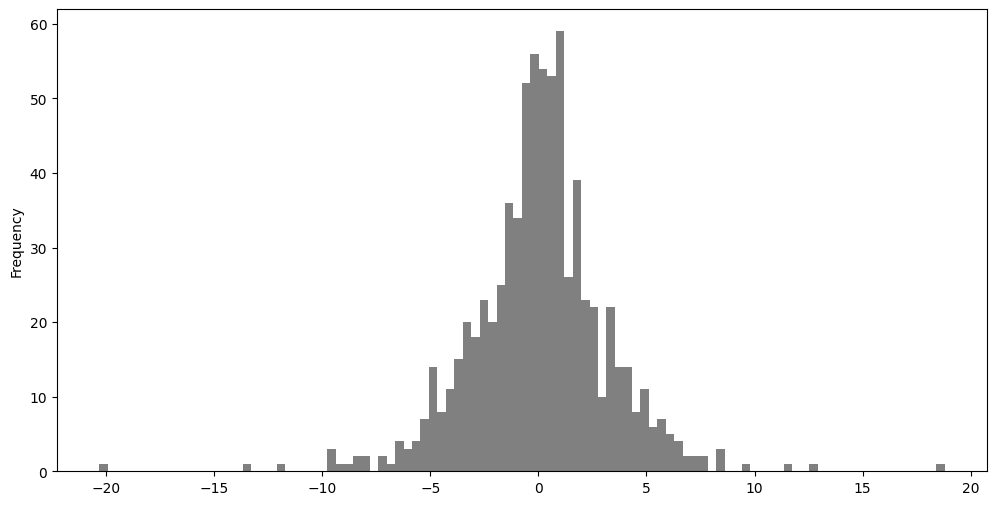

In [126]:
delta_prices["Delta Close"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

We could see that the delta means are approximately around 0 in absolute values, but +

In [127]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices_perc = (prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned) / prices_amazon_cleaned.shift(-1)
delta_prices_perc = delta_prices_perc.fillna(0)
delta_prices_perc.columns = ["Delta Open Perc", "Delta High Perc", "Delta Low Perc", "Delta Close Perc"]
delta_prices_perc

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-09-26,-0.008461,-0.008147,-0.010316,-0.008340
2019-09-27,-0.012166,-0.006711,-0.002691,0.006026
2019-09-30,0.010888,0.010333,0.011103,-0.000150
2019-10-01,-0.010569,-0.015449,-0.013730,-0.013086
2019-10-02,-0.008605,-0.002255,-0.011833,0.006489
...,...,...,...,...
2022-09-19,0.009647,-0.002492,-0.005448,-0.020214
2022-09-20,-0.007021,-0.005171,-0.022710,-0.030791
2022-09-21,-0.046208,-0.041839,-0.018837,-0.010485
2022-09-22,-0.009310,-0.023610,-0.037480,-0.031025


In [128]:
# And now we would see that the mean is around +0.2%
delta_prices_perc.describe()

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
count,755.000000,755.000000,755.000000,755.000000
mean,0.000082,0.000160,0.000114,0.000089
std,0.023799,0.020201,0.021405,0.023180
min,-0.094949,-0.116063,-0.153546,-0.163460
25%,-0.011163,-0.009001,-0.010246,-0.011196
50%,0.000462,0.000035,0.000752,0.000823
75%,0.012535,0.009463,0.011041,0.011633
max,0.098814,0.107592,0.108224,0.119221


<AxesSubplot: ylabel='Frequency'>

2022-09-26 12:41:31,291 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,294 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,296 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,298 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,302 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,306 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,309 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,313 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,316 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,320 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,324 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,327 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:41:31,331 - WA

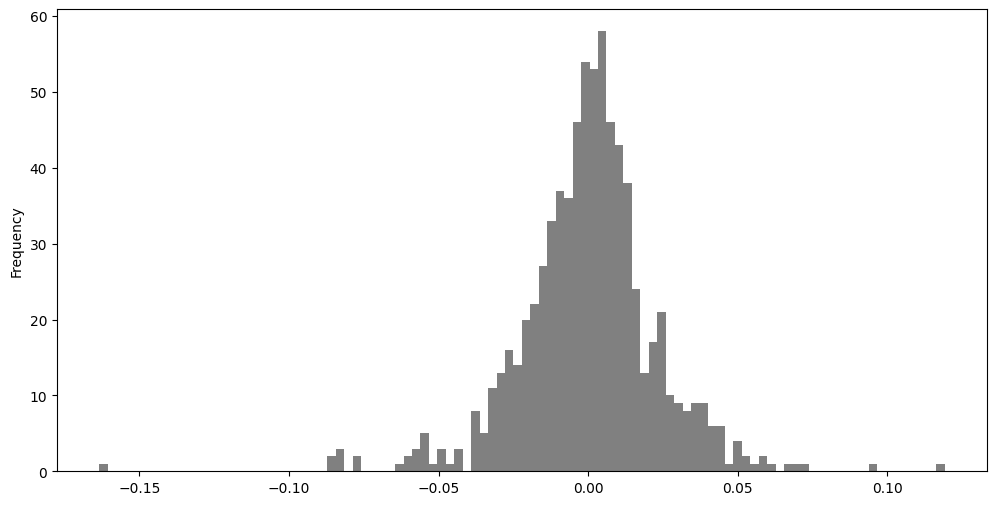

In [129]:
delta_prices_perc["Delta Close Perc"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

We can see that with large numbers, the variations of the prices follow a normal distribution.

<AxesSubplot: >

2022-09-26 12:25:16,554 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,556 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,558 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,570 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,573 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,576 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,580 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,583 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,586 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,589 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,593 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,596 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,599 - WA

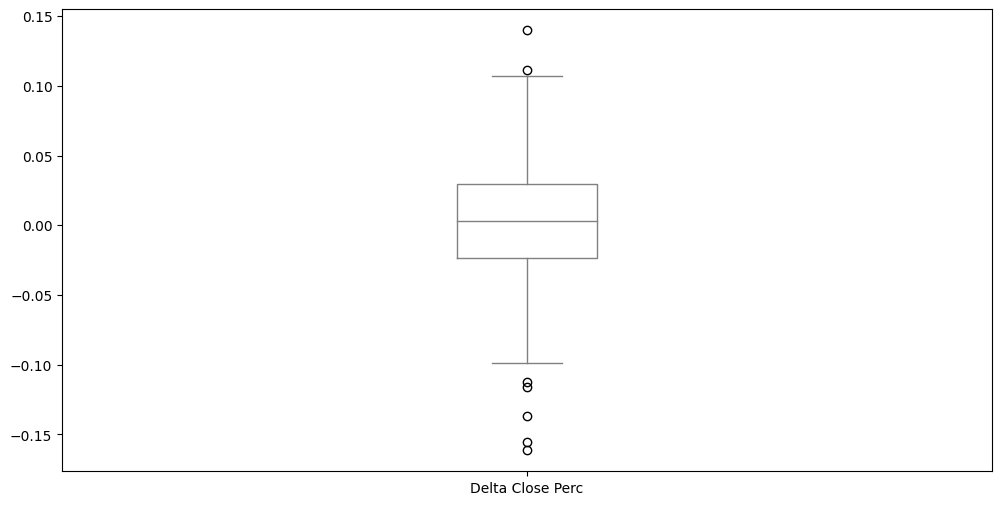

In [87]:
# We could also display a boxplot to know how it this variation
delta_prices_perc["Delta Close Perc"].plot(kind="box", figsize=(12, 6), color="gray")

### Bivariate Analysis

array([[<AxesSubplot: xlabel='Delta Open Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot: xlabel='Delta High Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot: xlabel='Delta Low Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot: xlabel='Delta Close Perc', ylabel='Delta Open Perc'>],
       [<AxesSubplot: xlabel='Delta Open Perc', ylabel='Delta High Perc'>,
        <AxesSubplot: xlabel='Delta High Perc', ylabel='Delta High Perc'>,
        <AxesSubplot: xlabel='Delta Low Perc', ylabel='Delta High Perc'>,
        <AxesSubplot: xlabel='Delta Close Perc', ylabel='Delta High Perc'>],
       [<AxesSubplot: xlabel='Delta Open Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot: xlabel='Delta High Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot: xlabel='Delta Low Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot: xlabel='Delta Close Perc', ylabel='Delta Low Perc'>],
       [<AxesSubplot: xlabel='Delta Open Perc', ylabel='Delta Close Perc'>,
        <AxesSubplot: xla

2022-09-26 12:33:42,403 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,405 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,408 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,411 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,414 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,419 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,421 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,424 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,426 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,429 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,431 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,434 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:42,442 - WA

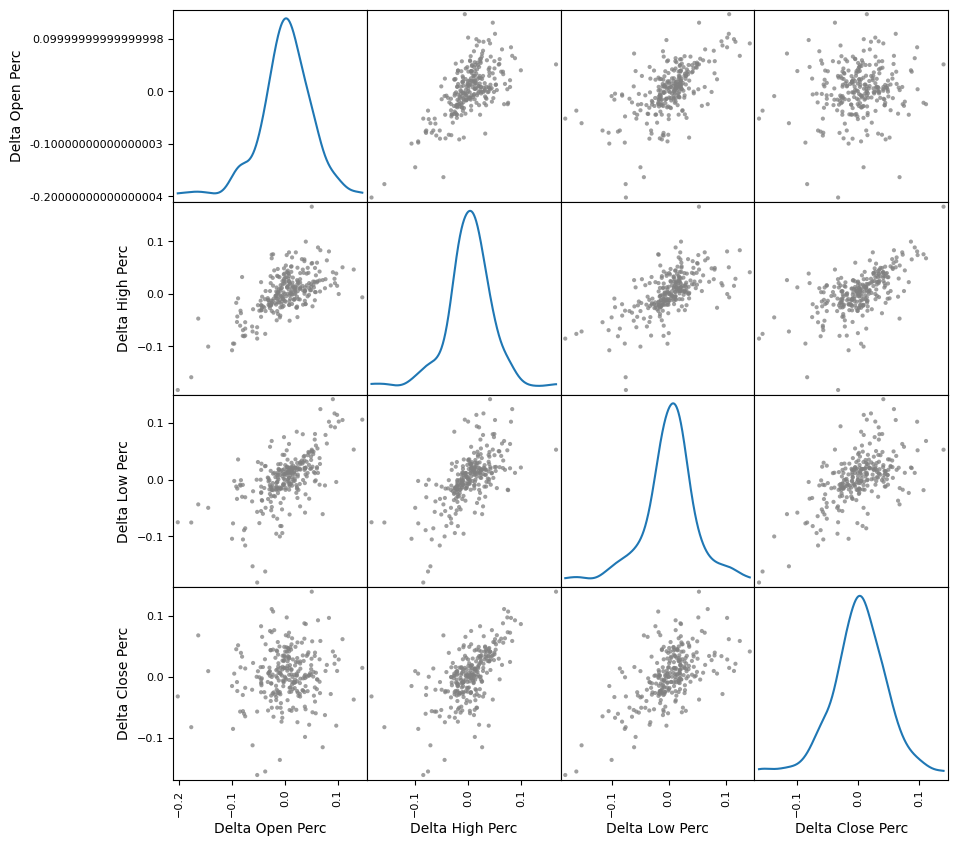

In [95]:
pd.plotting.\
    scatter_matrix(
        delta_prices_perc, 
        figsize=(10, 10), 
        color="gray", 
        alpha=0.75, 
        diagonal="kde")

2022-09-26 12:33:26,864 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,866 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,868 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,870 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,872 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,875 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,878 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,881 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,884 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,890 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,894 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,898 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,901 - WA

<AxesSubplot: >

2022-09-26 12:33:26,967 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,970 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,972 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,975 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,978 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,980 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,982 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,985 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,988 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,990 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,992 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,994 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:33:26,995 - WA

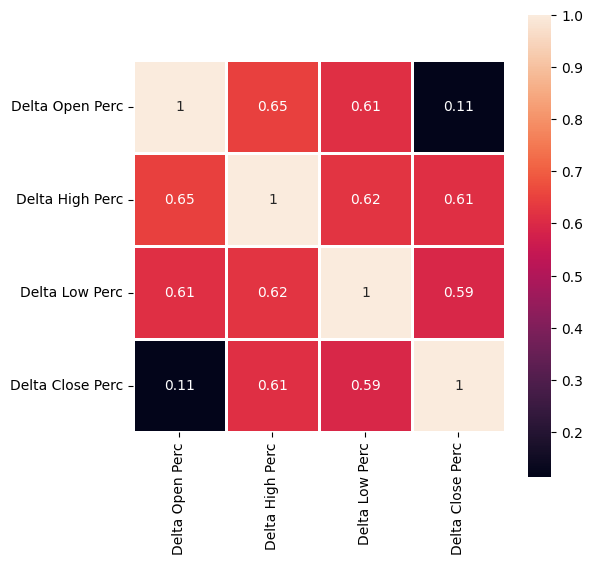

In [93]:
# We could create also a correlation heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(delta_prices_perc.corr(), annot=True, square=True, linewidths=2)

We can see that the Delta High Perc, has the most correlation with the other values (except with the close).

This indicates that it will be the chosen variable when creating a forecast in Amazon.
But this could change depending on the company.

In [107]:
agg_correlation = (delta_prices_perc.corr().sum(axis=0) - 1)
agg_correlation.idxmax()

'Delta High Perc'

2022-09-26 12:35:36,994 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:36,997 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:36,999 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,001 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,004 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,007 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,009 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,012 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,014 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,019 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,022 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,025 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,028 - WA

<AxesSubplot: >

2022-09-26 12:35:37,080 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,084 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,086 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,089 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,092 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,095 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,098 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,101 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,104 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,106 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,108 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,109 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:35:37,112 - WA

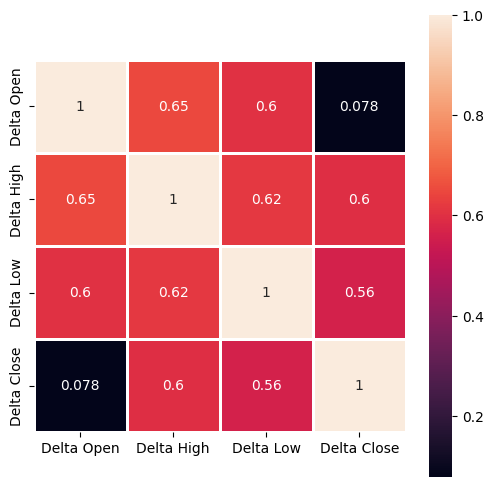

In [96]:
# We could look without percentages, if this relation holds
plt.figure(figsize=(6, 6))
sns.heatmap(delta_prices.corr(), annot=True, square=True, linewidths=2)

In [108]:
agg_correlation = (delta_prices.corr().sum(axis=0) - 1)
agg_correlation.idxmax()

'Delta High'

In [ ]:
# So we could create a function to select which would be the selected regressor on the price per week

# S&P 500 Companies

In [88]:
# We can get the S&P500 companies by reading directly to the table of wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

sp_companies = pd.read_html(wiki_url, header=0)[0]

sp_companies.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [90]:
# Select the companies that have changed
sp_companies_changed = pd.read_html(wiki_url, header=1)[1]
sp_companies_changed.head()

,Date,Ticker,Security,Ticker.1,Security.1,Reason
0,"September 19, 2022",CSGP,CoStar Group,PVH,PVH,Market capitalization change.[4]
1,"September 19, 2022",INVH,Invitation Homes,PENN,Penn Entertainment,Market capitalization change.[4]
2,"June 21, 2022",KDP,Keurig Dr Pepper,UA/UAA,Under Armour,Market capitalization change.[5]
3,"June 21, 2022",ON,ON Semiconductor,IPGP,IPG Photonics,Market capitalization change.[5]
4,"June 8, 2022",VICI,Vici Properties,CERN,Cerner,S&P 500 constituent Oracle Corp. acquired Cern...


- TODO: Remove outliers by inter-quantile range

- TODO: When computing delta_prices_perc, check for 0 in the divisor

- TODO: Install fonts for matplotlib
    - https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts

- TODO: PCA to detect in each case, which features to use -> feature engineering.
    - https://medium.com/@data.science.enthusiast/feature-selection-techniques-forward-backward-wrapper-selection-9587f3c70cfa

